## <u>Simulation Model:</u>

### <u>1. Mathematical Formulation (Final Simulation Model)</u>

We construct a nonlinear stochastic time series with autoregressive covariates and responses, 
 a latent state for sequential memory, input-dependent conditional variance, 
 and a tempered exponential output transformation.

##### <u>Covariate dynamics</u>
$$x_t = \rho_x \, x_{t-1} + \sigma_x \, \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0,1)$$

##### <u>Latent state dynamics</u>
$$s_t = \alpha_s \, s_{t-1} + \beta_x \, x_{t-1} + \beta_y \, y_{t-1} + \gamma_{xy} \, x_{t-1} \, y_{t-1}$$

##### <u>Conditional mean</u>
$$\mu_t = \lambda_s \, s_t + \sum_{i=1}^{3} \lambda_{x,i} \, x_{t-i} + \sum_{i=1}^{3} \lambda_{y,i} \, y_{t-i}$$

##### <u>Conditional variance</u>
$$\sigma_t^2 = \omega + \phi \, \sigma_{t-1}^2 + \psi_s \, s_t^2 + \sum_{i=1}^{3} \psi_{x,i} \, x_{t-i}^2 + \sum_{i=1}^{3} \psi_{y,i} \, y_{t-i}^2$$

##### <u>Latent pre-activation</u>
$$u_t = \mu_t + \sigma_t \, \eta_t, \qquad \eta_t \sim \mathcal{N}(0,1)$$

##### <u>Tempered exponential transformation</u>
$$y_t = \exp(\tau \, u_t)$$

### <u>2. Parameter Specification</u>

##### <u>Covariate AR(1)</u>
$$\rho_x = 0.75, \quad \sigma_x = 0.5$$

##### <u>Latent state coefficients</u>
$$\alpha_s = 0.4, \quad \beta_x = 0.2, \quad \beta_y = 0.2, \quad \gamma_{xy} = 0.1$$

##### <u>Mean coefficients</u>
$$\lambda_s = 0.5, \\[0.5em]
\lambda_{x,i} = (0.15, 0.1, 0.05), \quad \lambda_{y,i} = (0.15, 0.1, 0.05)$$

##### <u>Variance coefficients</u>
$$\omega = 0.1, \quad \phi = 0.2, \quad \psi_s = 0.2, \\[0.5em]
 \psi_{x,i} = (0.1, 0.05, 0.01), \quad \psi_{y,i} = (0.1, 0.05, 0.01)$$

##### <u>Tempering coefficient</u>
$$\tau = 0.15$$

##### <u>Burn-in period</u>
$$T_{\text{burn}} = 1000$$

In [19]:
# Import libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
from matplotlib.ticker import AutoMinorLocator

In [20]:
def simulation(T=7000, seed=1):
    """
    Latent state model with tempered exponential link:
        s_t       = 0.4 * s_{t-1} + 0.2 * x_{t-1} + 0.2 * y_{t-1} + 0.025 * x_{t-1} * y_{t-1}
        mu_t      = 0.5 * s_t + sum_i lambda_y[i]*y_{t-i} + sum_j lambda_x[j]*x_{t-j}
        sigma_t^2 = 0.2 + 0.2 * sigma_{t-1}^2 + 0.05 * s_t^2 + sum_i psi_y[i]*y_{t-i}^2 + sum_j psi_x[j]*x_{t-j}^2
        y_t       = exp(0.15 * (mu_t + sigma_t * eps)), eps ~ N(0,1)
    """
    rng = np.random.default_rng(seed)

    # Fixed parameters from your specification
    rho_x, sigma_x = 0.75, 0.5
    alpha_s, beta_x, beta_y, gamma_xy = 0.4, 0.2, 0.2, 0.1
    lambda_s = 0.5
    lambda_x = np.array([0.15, 0.1, 0.05])
    lambda_y = np.array([0.15, 0.1, 0.05])
    omega, phi, psi_s = 0.1, 0.2, 0.2
    psi_x = np.array([0.1, 0.05, 0.01])
    psi_y = np.array([0.1, 0.05, 0.01])
    tau = 0.15
    T_burn = 1000

    total = T + T_burn

    # storage
    x = np.zeros(total + 1, dtype=float)
    y = np.zeros(total + 1, dtype=float)
    s = np.zeros(total + 1, dtype=float)
    mu = np.zeros(total + 1, dtype=float)
    sig = np.zeros(total + 1, dtype=float)
    sigma2_prev = np.zeros(total + 1, dtype=float)

    start = 5

    # init x as AR(1)
    x[0] = rng.standard_normal()
    for t in range(1, start):
        x[t] = rho_x * x[t - 1] + sigma_x * rng.standard_normal()

    # init y and s
    y[:start] = np.exp(tau * rng.standard_normal(start))
    s[:start] = rng.standard_normal(start) * 0.1
    sigma2_prev[:start] = omega

    for t in range(start, total + 1):
        # update x_t
        x[t] = rho_x * x[t - 1] + sigma_x * rng.standard_normal()

        # update latent state s_t
        s[t] = (alpha_s * s[t - 1] + 
                beta_x * x[t - 1] + 
                beta_y * y[t - 1] + 
                gamma_xy * x[t - 1] * y[t - 1])

        # mean (3 lags)
        x_lags = x[t - 1 : t - 4 : -1]  # 3 lags
        y_lags = y[t - 1 : t - 4 : -1]  # 3 lags
        mu_t = (lambda_s * s[t] + 
                (lambda_y @ y_lags) + 
                (lambda_x @ x_lags))
        mu[t] = mu_t

        # variance structure
        x2 = x[t - 1 : t - 4 : -1] ** 2
        y2 = y[t - 1 : t - 4 : -1] ** 2
        sigma2 = (omega + 
                  phi * sigma2_prev[t - 1] + 
                  psi_s * s[t] ** 2 + 
                  (psi_y @ y2) + 
                  (psi_x @ x2))
        
        sigma2_prev[t] = sigma2
        sig[t] = np.sqrt(sigma2)

        # pre-additive noise structure
        u = mu_t + sig[t] * rng.standard_normal()
        y[t] = np.exp(tau * u)

    # drop burn-in
    sl = slice(T_burn + 1, None)
    x_t, y_t, mu_t, sigma_t = x[sl], y[sl], mu[sl], sig[sl]

    # Return
    return x_t, y_t, mu_t, sigma_t

### <u>2. Synthetic dataset generation</u>


In [23]:
# Train validation set generation:
x_t, y_t, mu_t, sigma_t = simulation(T=7000, seed=1)

df_train_val = pd.DataFrame({
    "x_t": x_t,
    "y_t": y_t,
    "mu_t": mu_t,
    "sigma_t": sigma_t
})

# Export for safety and later use
#df_train_val.to_csv("simulation_train_val.csv", index=False)



# Test set generation:
x_t_test, y_t_test, mu_t_test,sigma_t_test = simulation(T=7000, seed=12)

df_test = pd.DataFrame({
    "x_t": x_t_test,
    "y_t": y_t_test,
    "mu_t": mu_t_test,
    "sigma_t": sigma_t_test
})

# Export for safety and later use
#df_test.to_csv("simulation_test.csv", index=False)

In [35]:
df_train_val = pd.read_csv("simulation_train_val.csv")
df_test = pd.read_csv("simulation_test.csv")
df_test.head()

,x_t,y_t,mu_t,sigma_t
0,0.102668,0.800667,0.167359,0.665126
1,-0.249761,0.952148,0.301528,0.597996
2,-0.718737,1.118695,0.325842,0.569333
3,-0.350577,0.956586,0.215718,0.630792
4,-0.173258,1.050419,0.225977,0.619955


In [27]:
print(len(df_train_val))
print(len(df_test))


7000
7000


In [28]:
y_train_val = df_train_val['y_t']
y_test = df_test['y_t']
threshold_995 = np.quantile(y_train_val[:5000], 0.995)


exceed_val  = np.sum(y_train_val[5000:] > threshold_995)
exceed_test = np.sum(y_test > threshold_995)

print(
    f"Threshold (0.995, first 5000): {threshold_995:.3f}\n"
    f"Validation exceedances: {exceed_val}\n"
    f"Test exceedances: {exceed_test}\n"
    f"max y_train_val: {np.max(y_train_val)}\n"
    f"max y_test: {np.max(y_test)}"
)

Threshold (0.995, first 5000): 1.528
Validation exceedances: 18
Test exceedances: 56
max y_train_val: 1.861403636413722
max y_test: 1.9817932858320868


### <u>3. Time series plot:</u>

#### **Train Validation Set**

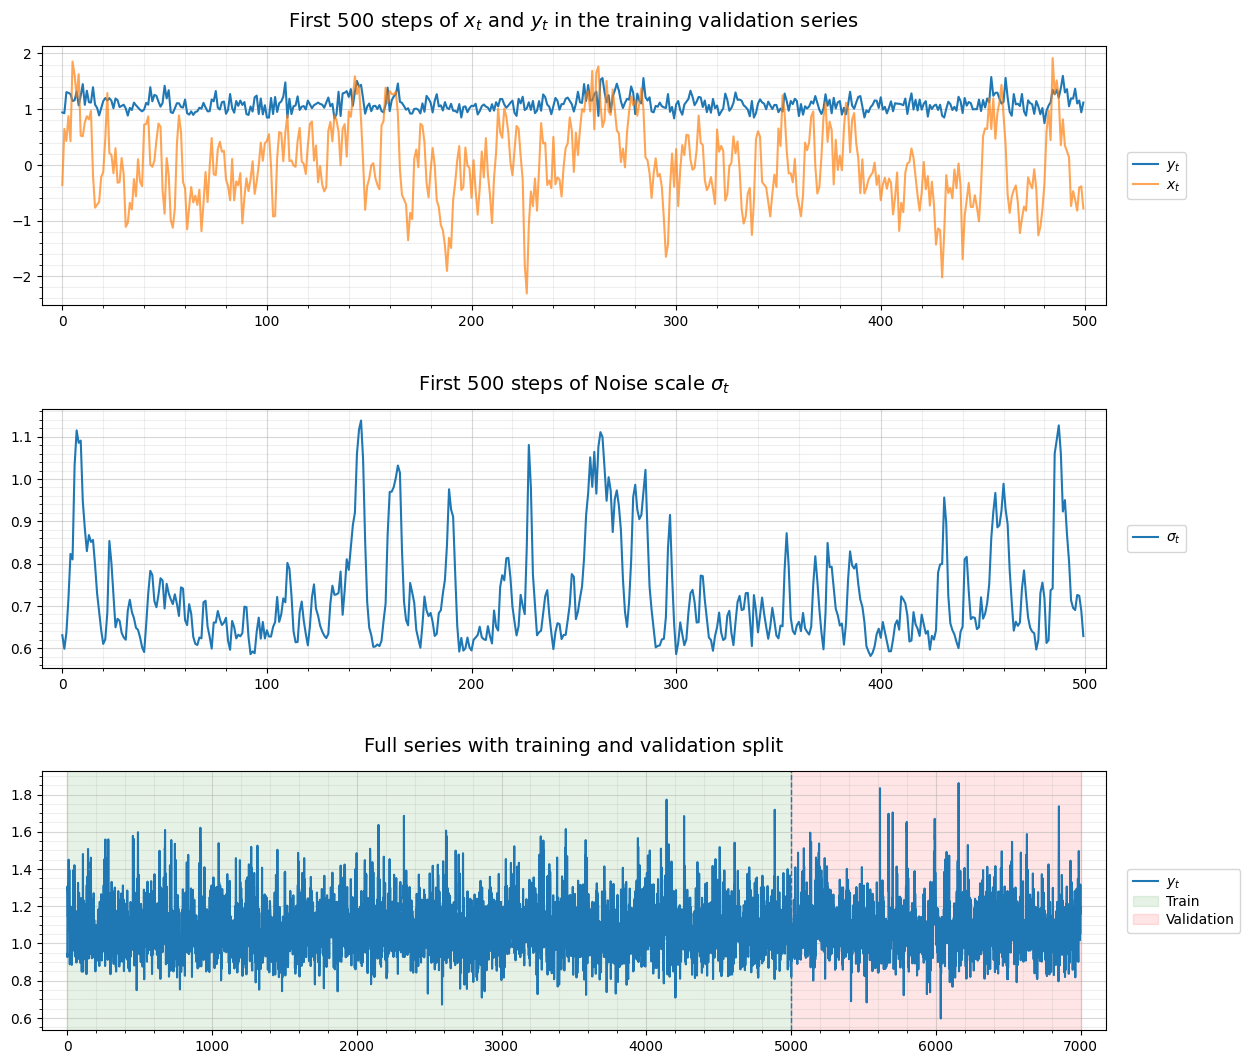

In [29]:
# ===== Train Validation set ===== #

# Plotting parameters
window = 500
n_train = 5000
pad = 10
LEGEND_SIZE = 10
TICK_SIZE = 10

x = df_train_val["x_t"].to_numpy()
y = df_train_val["y_t"].to_numpy()
sigma = df_train_val["sigma_t"].to_numpy()

fig = plt.figure(figsize=(14, 12))
ax0 = fig.add_subplot(3, 1, 1)
ax1 = fig.add_subplot(3, 1, 2, sharex=ax0)
ax2 = fig.add_subplot(3, 1, 3)

# vertical spacing and margins
fig.subplots_adjust(left=0.08, right=0.84, hspace=0.4, top=0.93)

# first 500 points: y_t and x_t
ax0.plot(y[:window], label=r"$y_t$")
ax0.plot(x[:window], label=r"$x_t$", alpha=0.7)
ax0.set_title(r"First 500 steps of $x_t$ and $y_t$ in the training validation series",
              fontsize=14, pad=14)
ax0.grid(alpha=0.5)

# sigma_t
ax1.plot(sigma[:window], label=r"$\sigma_t$")
ax1.set_title(r"First 500 steps of Noise scale $\sigma_t$", fontsize=14, pad=14)
ax1.grid(alpha=0.5)

# apply identical padding for first two panels
ax0.set_xlim(-pad, window + pad)
ax1.set_xlim(-pad, window + pad)

for a in (ax0, ax1):
    a.margins(x=0.01)
    a.tick_params(labelsize=TICK_SIZE)
    a.xaxis.set_minor_locator(AutoMinorLocator())
    a.yaxis.set_minor_locator(AutoMinorLocator())
    a.grid(which="minor", alpha=0.2)
    a.legend(fontsize=LEGEND_SIZE, loc="center left",
             bbox_to_anchor=(1.02, 0.5),
             handlelength=1.8, handletextpad=0.6,
             borderaxespad=0.0, labelspacing=0.3)

# full series with training and validation shading
ax2.plot(y, label=r"$y_t$")
ax2.axvspan(0, n_train - 1, color="green", alpha=0.1, label="Train")
ax2.axvspan(n_train, len(y) - 1, color="red", alpha=0.1, label="Validation")
ax2.axvline(n_train, linestyle="--", linewidth=1)
ax2.set_title("Full series with training and validation split", fontsize=14, pad=14)
ax2.grid(alpha=0.5)

T = len(y)
pad_last = max(5, int(0.025 * T))
ax2.set_xlim(-pad_last, T - 1 + pad_last)
ax2.margins(x=0.01)
ax2.tick_params(labelsize=TICK_SIZE)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(which="minor", alpha=0.2)
ax2.legend(fontsize=LEGEND_SIZE, loc="center left",
           bbox_to_anchor=(1.02, 0.5),
           handlelength=1.8, handletextpad=0.6,
           borderaxespad=0.0, labelspacing=0.3)

plt.show()


#### **Test set**

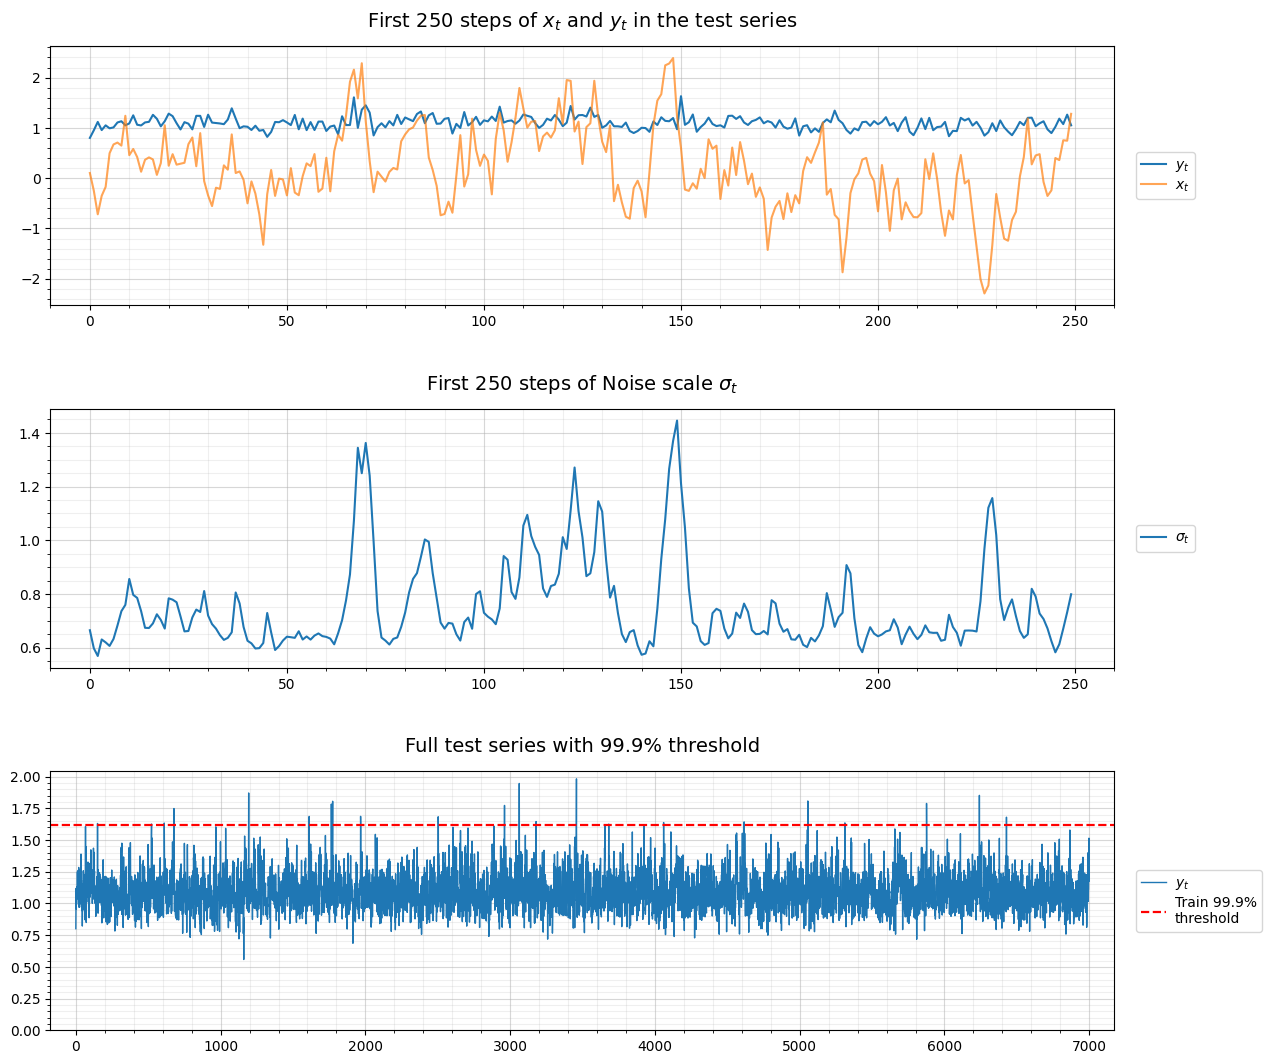

In [30]:
# ===== TEST set ===== #

# Plotting parameters
window = 250
n_train = 5000
pad = 10
LEGEND_SIZE = 10
TICK_SIZE = 10

threshold_999 = np.quantile(df_train_val["y_t"].to_numpy()[:n_train], 0.999)

x_te = df_test["x_t"].to_numpy()
y_te = df_test["y_t"].to_numpy()
sigma_te = df_test["sigma_t"].to_numpy()

fig = plt.figure(figsize=(14, 12))
ax0 = fig.add_subplot(3, 1, 1)
ax1 = fig.add_subplot(3, 1, 2, sharex=ax0)
ax2 = fig.add_subplot(3, 1, 3)

# a bit more vertical space and top margin
fig.subplots_adjust(left=0.08, right=0.84, hspace=0.4, top=0.93)

# ---- first 200 points: y_t and x_t ----
ax0.plot(y_te[:window], label=r"$y_t$")
ax0.plot(x_te[:window], label=r"$x_t$", alpha=0.7)
ax0.set_title(r"First 250 steps of $x_t$ and $y_t$ in the test series", fontsize=14, pad=14)
ax0.grid(alpha=0.5)

# ---- sigma_t ----
ax1.plot(sigma_te[:window], label=r"$\sigma_t$")
ax1.set_title(r"First 250 steps of Noise scale $\sigma_t$", fontsize=14, pad=14)
ax1.grid(alpha=0.5)

# ---- consistent padding + cosmetics for top two panels ----
ax0.set_xlim(-pad, window + pad)
for a in (ax0, ax1):
    a.margins(x=0.01)
    a.tick_params(labelsize=TICK_SIZE)
    a.xaxis.set_minor_locator(AutoMinorLocator())
    a.yaxis.set_minor_locator(AutoMinorLocator())
    a.grid(which="minor", alpha=0.2)
    a.legend(fontsize=LEGEND_SIZE, loc="center left",
             bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0,
             handlelength=1.8, handletextpad=0.6, labelspacing=0.3)

# ---- full test series with 99.9% threshold from TRAIN ----
ax2.plot(y_te, label=r"$y_t$", linewidth=1.0)
ax2.axhline(threshold_999, ls="--", lw=1.6, color="red",
            label="Train 99.9%\nthreshold")
ax2.set_title("Full test series with 99.9% threshold", fontsize=14, pad=14)
ax2.grid(alpha=0.5)
ax2.margins(x=0.01)
ax2.tick_params(labelsize=TICK_SIZE)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(which="minor", alpha=0.2)
ax2.legend(fontsize=LEGEND_SIZE, loc="center left",
           bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0,
           handlelength=1.8, handletextpad=0.6, labelspacing=0.3)

# same side padding and a little vertical headroom above the threshold
T_te = len(y_te)
pad_last = max(5, int(0.025 * T_te))
ax2.set_xlim(-pad_last, T_te - 1 + pad_last)
y_top = max(threshold_999, y_te.max()) * 1.03
ax2.set_ylim(bottom=min(0, y_te.min()), top=y_top)

plt.show()


#### **ACF-PACF Train-set**

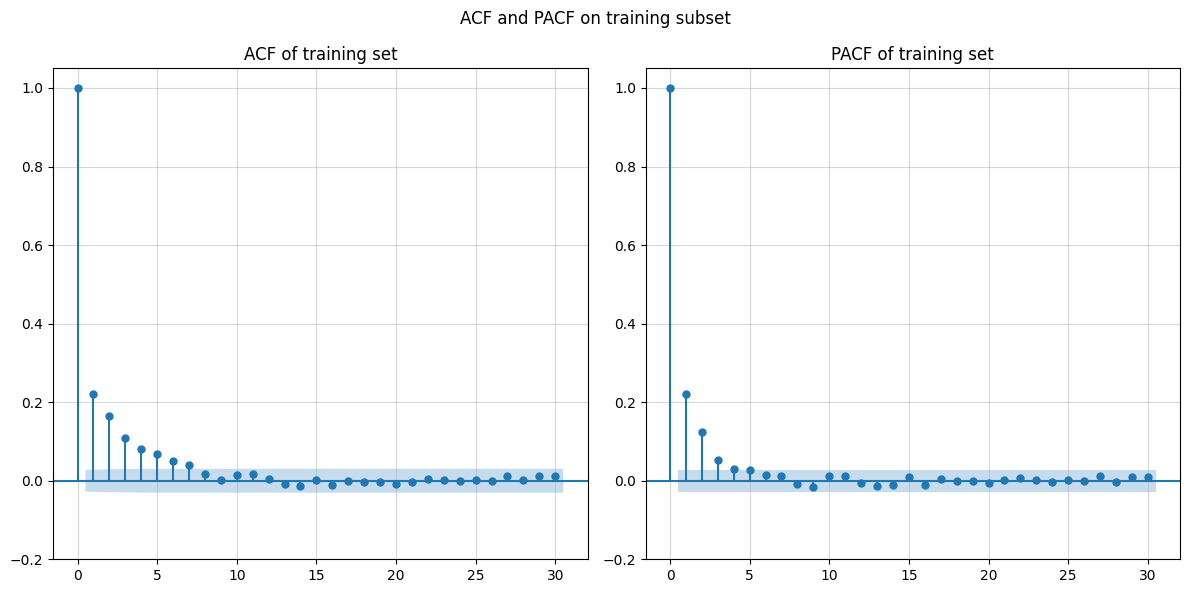

In [31]:
n_train = 5000
y_train = df_train_val["y_t"].to_numpy()[:n_train]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(y_train, lags=30, ax=axs[0])
plot_pacf(y_train, lags=30, ax=axs[1])  #

axs[0].set_ylim(-0.2, 1.05)
axs[1].set_ylim(-0.2, 1.05)

axs[0].set_title("ACF of training set")
axs[1].set_title("PACF of training set")
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)

plt.suptitle("ACF and PACF on training subset")
plt.tight_layout()
plt.show()


### <u> 4. True Quantile: </u>

In [32]:
def quantile_dataframe(y_t, mu_t, sigma_t, tau, index=None):

    """
    Create a DataFrame with y_t, q10, q50, q90 for tempered exponential model.
    Args:
        y_t     : array of shape (T,)
        mu_t    : array of shape (T,)
        sigma_t : array of shape (T,)
        tau     : tempered exponential parameter
        index   : optional pandas Index of length T
    Returns:
        df : pandas DataFrame with columns ['y_t', 'q10', 'q50', 'q90']
    """
    
    y_t = np.asarray(y_t)
    mu_t = np.asarray(mu_t)
    sigma_t = np.asarray(sigma_t)
    if not (y_t.shape == mu_t.shape == sigma_t.shape):
        raise ValueError("y_t, mu_t, and sigma_t must have the same shape")
    
    # Normal quantiles for 0.1, 0.5, 0.9
    z = norm.ppf([0.1, 0.5, 0.9])
    
    # Latent quantiles: u = mu_t + sigma_t * z
    u = mu_t[:, None] + sigma_t[:, None] * z[None, :]
    
    # Tempered exponential transformation: y = exp(tau * u)
    q = np.exp(tau * u)
    
    df = pd.DataFrame(
        {
            "y_t": y_t,
            "q10": q[:, 0],
            "q50": q[:, 1],
            "q90": q[:, 2],
        },
        index=index
    )
    return df

In [ ]:
# Quantiles train_validation set
q_train_val = quantile_dataframe(
    y_t= df_train_val["y_t"].to_numpy(),
    mu_t= df_train_val["mu_t"].to_numpy(),
    sigma_t= df_train_val["sigma_t"].to_numpy(),
    tau=0.15,
    index=df_train_val.index
)

#q_train_val.to_csv("true_quantiles_train_val.csv", index=False)


# Quantiles test set
q_test = quantile_dataframe(
    y_t= df_test["y_t"].to_numpy(),
    mu_t= df_test["mu_t"].to_numpy(),
    sigma_t= df_test["sigma_t"].to_numpy(),
    tau=0.15,
    index=df_test.index
)

#q_test.to_csv("true_quantiles_test.csv", index=False)


In [34]:
q_train_val = pd.read_csv("true_quantiles_train_val.csv")
q_test = pd.read_csv("true_quantiles_test.csv")

q_test.head(3)

,y_t,q10,q50,q90
0,0.800667,0.902348,1.025422,1.165282
1,0.952148,0.932650,1.046268,1.173726
2,1.118695,0.941230,1.050090,1.171542


### <u> Figure 5 ( Section 4.1):</u>

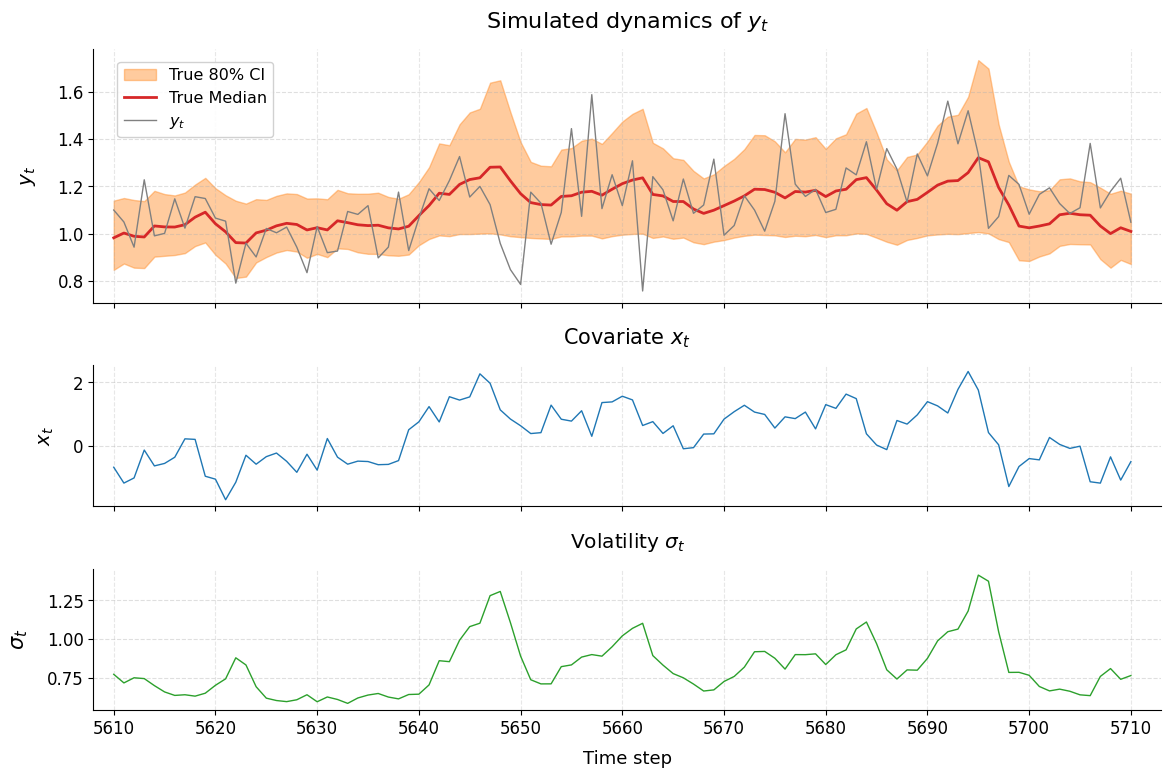

In [36]:
# 3-panel vertical plot: Fan chart, x_t and volatility 
window = 101 #101
start = 5610 #100

fig, axs = plt.subplots(3, 1, figsize=(12, 7.6), sharex=True, gridspec_kw={'height_ratios': [1.8, 1, 1]})

# Prepare data slices
y_w = df_test["y_t"].iloc[start:start+window]
q10_w = q_test["q10"].iloc[start:start+window]
q50_w = q_test["q50"].iloc[start:start+window]
q90_w = q_test["q90"].iloc[start:start+window]
x_w = df_test["x_t"].iloc[start:start+window]
sigma_w = df_test["sigma_t"].iloc[start:start+window]
time_w = np.arange(start, start+window)

# Panel 1: Fan chart with observed y_t
axs[0].fill_between(time_w, q10_w, q90_w, color="#ff7f0e", alpha=0.4, label="True 80% CI")
axs[0].plot(time_w, q50_w, color="#d62728", linewidth=2, label="True Median")
axs[0].plot(time_w, y_w, color="gray", linewidth=1, label=r"$y_t$")
axs[0].set_title("Simulated dynamics of $y_t$", fontsize=16, pad=15)
axs[0].set_ylabel(r"$y_t$", fontsize=14.5, labelpad=14)
axs[0].legend(loc="upper left", fontsize=11.5, framealpha=0.9, bbox_to_anchor=(0.015, 0.98))
axs[0].grid(True, linestyle="--", alpha=0.4)
axs[0].tick_params(labelsize=12)

# Panel 2: Covariate x_t
axs[1].plot(time_w, x_w, color="#1f77b4", linewidth=1)
axs[1].set_title("Covariate $x_t$", fontsize=15, pad=15)
axs[1].set_ylabel(r"$x_t$", fontsize=14, labelpad=12)
axs[1].grid(True, linestyle="--", alpha=0.4)
axs[1].tick_params(labelsize=12.5)

# Panel 3: Volatility sigma_t
axs[2].plot(time_w, sigma_w, color="#2ca02c", linewidth=1)
axs[2].set_title(r"Volatility $\sigma_t$", fontsize=14.5, pad=15)
axs[2].set_ylabel(r"$\sigma_t$", fontsize=15, labelpad=12)
axs[2].set_xlabel("Time step", fontsize=13, labelpad=9)
axs[2].grid(True, linestyle="--", alpha=0.4)
axs[2].tick_params(labelsize=12.5)

# Set x-axis limits with small padding
for ax in axs:
    ax.set_xlim(start-2, start + window + 2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Custom x-ticks and grid lines
xticks = np.arange(start, start + window + 1, 10)
for ax in axs:
    ax.set_xticks(xticks)
    ax.grid(True, which="major", axis="x", linestyle="--", alpha=0.3)

axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)
axs[2].tick_params(labelsize=12)    

plt.subplots_adjust(left=0.08, right=0.97, top=0.95, bottom=0.08, hspace=0.35)
plt.savefig("fan_x_sigma.pdf", bbox_inches='tight', dpi=600)
plt.show()

### <u>Figure 6 ( Section 4.2):</u>

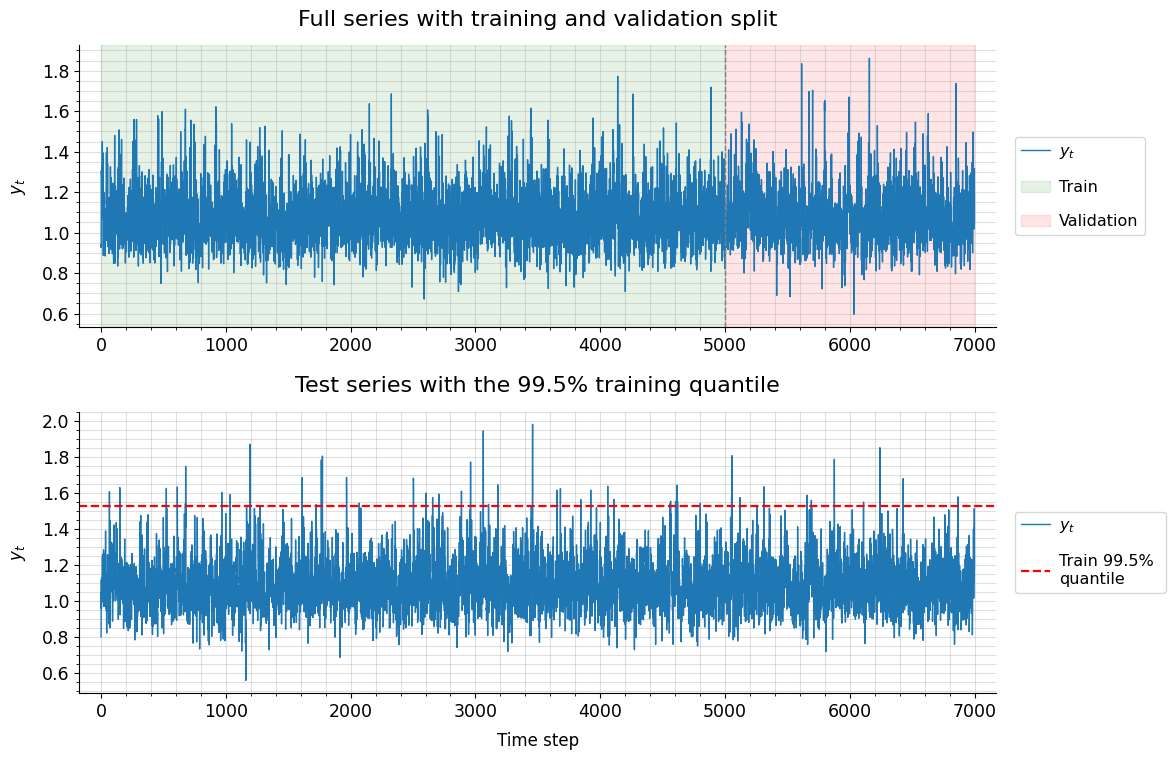

In [37]:
# Plotting parameters
n_train = 5000

# Data
x = df_train_val["x_t"].to_numpy()
y = df_train_val["y_t"].to_numpy()
sigma = df_train_val["sigma_t"].to_numpy()
y_te = df_test["y_t"].to_numpy()

# Threshold for test panel (from traininig set)
threshold_995 = np.quantile(y[:n_train], 0.995)

fig, axs = plt.subplots(2, 1, figsize=(12, 7.7), sharex=False, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(hspace=0.4, left=0.07, right=0.98, top=0.93, bottom=0.10)

# Panel 1: Full train/val series with split 
axs[0].plot(y, label=r"$y_t$", color="#1f77b4", linewidth=1)
axs[0].axvspan(0, n_train - 1, color="green", alpha=0.10, label="Train")
axs[0].axvspan(n_train, len(y) - 1, color="red", alpha=0.10, label="Validation")
axs[0].axvline(n_train, linestyle="--", linewidth=1, color="gray")
axs[0].set_title("Full series with training and validation split", fontsize=16, pad=14)
axs[0].grid(alpha=0.4)
T = len(y)
pad_last = max(5, int(0.025 * T))
axs[0].set_xlim(-pad_last, T - 1 + pad_last)
axs[0].tick_params(labelsize=11)
axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0].grid(which="minor", alpha=0.4)
axs[0].legend(fontsize=11.5, loc="center left", bbox_to_anchor=(1.02, 0.5), handlelength=1.8, handletextpad=0.6, borderaxespad=0.0, labelspacing=1.2)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_ylabel(r"$y_t$", fontsize=12, labelpad=10)

# Panel 2: Full test series with 99.5% threshold 
axs[1].plot(y_te, label=r"$y_t$", color="#1f77b4", linewidth=1)
axs[1].axhline(threshold_995, ls="--", lw=1.6, color="red", label="Train 99.5% \nquantile")
axs[1].set_title("Test series with the 99.5% training quantile", fontsize=16, pad=14)
axs[1].set_xlabel("Time step", fontsize=12, labelpad=8)
axs[1].set_ylabel(r"$y_t$", fontsize=12, labelpad=10)
axs[1].grid(alpha=0.4)
T_te = len(y_te)
pad_last_te = max(5, int(0.025 * T_te))
axs[1].set_xlim(-pad_last_te, T_te - 1 + pad_last_te)
y_top = max(threshold_995, y_te.max()) * 1.03
axs[1].tick_params(labelsize=11)
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1].grid(which="minor", alpha=0.4)
axs[1].legend(fontsize=11.5, loc="center left", bbox_to_anchor=(1.02, 0.5), handlelength=1.8, handletextpad=0.6, borderaxespad=0.0, labelspacing=1.2)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[0].tick_params(labelsize=12.5)
axs[1].tick_params(labelsize=12.5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig('train_test_series.pdf', 
            bbox_inches='tight', dpi=600)
plt.show()
